# Libraries

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torch.optim.lr_scheduler import StepLR
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Device configuration
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')


/root/miniconda3/envs/torch2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Model

In [5]:
import torch
import torch.nn as nn

class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        # self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(25088, 4096), #(512*7*7)
            nn.ReLU(inplace=True),
            # nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            # nn.Dropout(),
            nn.Linear(4096, 10)
        )

    def forward(self, x):
        x = self.features(x)
        # x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
    
# Instantiate the VGG model
vgg16 = VGG()

# Print the model architecture
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [7]:
# Count the number of parameters in the model
total_params = sum(p.numel() for p in vgg16.parameters())
print(f'Total parameters in the VGG model: {total_params}')

Total parameters in the VGG model: 134301514


# Dataset Loader

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torch.optim.lr_scheduler import StepLR
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the GPU
vgg16.to(device)

# Define transformations
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Download the dataset
train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Splitting the dataset into train and validation using StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
train_indices, val_indices = next(sss.split(np.zeros(len(train_dataset)), train_dataset.targets))

# Create data loaders
train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_indices)
val_sampler = torch.utils.data.sampler.SubsetRandomSampler(val_indices)

train_loader = DataLoader(train_dataset, batch_size=128, sampler=train_sampler, num_workers=4)
val_loader = DataLoader(train_dataset, batch_size=128, sampler=val_sampler, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


In [23]:
# Save the DataLoader objects to a pickle file
data_loaders = {'train_loader': train_loader, 'val_loader': val_loader, 'test_loader': test_loader}

with open('data_loaders_final.pkl', 'wb') as file:
    pickle.dump(data_loaders, file)

In [3]:
import pickle
def load_loaders(file_path):
    with open(file_path, 'rb') as file:
        loaders = pickle.load(file)
    return loaders['train_loader'], loaders['val_loader'], loaders['test_loader']
train_loader, valid_loader, test_loader = load_loaders('data_loaders_final.pkl')

In [4]:
from torch.utils.data.dataset import Subset

# Calculate the size of the subset (10% of the original dataset)
subset_size = int(0.1 * len(train_loader.dataset))
subset_indices = torch.randperm(len(train_loader.dataset))[:subset_size]
# Create a subset using Subset class from torch.utils.data.dataset
subset = Subset(train_loader.dataset, subset_indices)
# Create a new DataLoader for the subset
train_loader_SI = DataLoader(subset, batch_size=train_loader.batch_size, shuffle=True, num_workers=train_loader.num_workers)

In [5]:
from torch.utils.data.dataset import Subset

# Calculate the size of the subset (10% of the original dataset)
subset_size = int(0.1 * len(test_loader.dataset))
subset_indices = torch.randperm(len(test_loader.dataset))[:subset_size]
# Create a subset using Subset class from torch.utils.data.dataset
subset = Subset(test_loader.dataset, subset_indices)
# Create a new DataLoader for the subset
test_loader_SI = DataLoader(subset, batch_size=test_loader.batch_size, shuffle=True, num_workers=test_loader.num_workers)

In [6]:
# Save the DataLoader objects to a pickle file
data_loaders = {'train_loader_SI': train_loader_SI,'test_loader_SI': test_loader_SI}

with open('data_loaders_SI.pkl', 'wb') as file:
    pickle.dump(data_loaders, file)

In [7]:
from data_complexity_measures.models.ARH_SeparationIndex import ARH_SeparationIndex

# Training

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

# Define the loss function, optimizer, and learning rate scheduler with reduced learning rate
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = StepLR(optimizer, step_size=50, gamma=0.1)

# Training loop
num_epochs = 200

# Lists to store losses and accuracies
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_val_accuracy = 0.0

for epoch in tqdm(range(num_epochs)):
    vgg16.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
        optimizer.zero_grad()
        
        outputs = vgg16(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = 100 * correct_train / total_train
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {running_loss/len(train_loader):.4f}, Train Acc: {train_accuracy:.2f}%')

    # Validation
    vgg16.eval()
    correct_val = 0
    total_val = 0
    val_loss = 0.0
    
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
            outputs = vgg16(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_accuracy = 100 * correct_val / total_val
    print(f'Epoch {epoch+1}/{num_epochs}, Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_accuracy:.2f}%')

    # Append values for plotting
    train_losses.append(running_loss/len(train_loader))
    val_losses.append(val_loss/len(val_loader))
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    # Save the model with the best validation accuracy
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(vgg16.state_dict(), 'best_model_weights.pth')

    # Adjust learning rate
    scheduler.step()


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1/200, Train Loss: 2.0891, Train Acc: 18.78%
Epoch 1/200, Val Loss: 1.7897, Val Acc: 29.46%


  0%|          | 1/200 [00:12<41:52, 12.62s/it]

Epoch 2/200, Train Loss: 1.6832, Train Acc: 35.16%
Epoch 2/200, Val Loss: 1.5221, Val Acc: 43.86%


  1%|          | 2/200 [00:25<42:27, 12.87s/it]

Epoch 3/200, Train Loss: 1.4089, Train Acc: 48.02%
Epoch 3/200, Val Loss: 1.2865, Val Acc: 52.36%


  2%|▏         | 3/200 [00:38<42:17, 12.88s/it]

Epoch 4/200, Train Loss: 1.2104, Train Acc: 56.22%
Epoch 4/200, Val Loss: 1.0894, Val Acc: 60.48%


  2%|▏         | 4/200 [00:51<42:35, 13.04s/it]

Epoch 5/200, Train Loss: 1.0485, Train Acc: 62.54%
Epoch 5/200, Val Loss: 1.0050, Val Acc: 64.34%


  2%|▎         | 5/200 [01:04<42:21, 13.03s/it]

Epoch 6/200, Train Loss: 0.9340, Train Acc: 67.13%
Epoch 6/200, Val Loss: 0.9294, Val Acc: 68.08%


  3%|▎         | 6/200 [01:17<41:26, 12.82s/it]

Epoch 7/200, Train Loss: 0.8360, Train Acc: 70.91%
Epoch 7/200, Val Loss: 0.7977, Val Acc: 71.94%


  4%|▎         | 7/200 [01:30<41:43, 12.97s/it]

Epoch 8/200, Train Loss: 0.7696, Train Acc: 73.55%
Epoch 8/200, Val Loss: 0.7392, Val Acc: 74.66%


  4%|▍         | 8/200 [01:43<41:28, 12.96s/it]

Epoch 9/200, Train Loss: 0.6962, Train Acc: 76.14%
Epoch 9/200, Val Loss: 0.7003, Val Acc: 75.70%


  4%|▍         | 9/200 [01:56<41:06, 12.91s/it]

Epoch 10/200, Train Loss: 0.6504, Train Acc: 77.79%
Epoch 10/200, Val Loss: 0.6727, Val Acc: 77.30%


  5%|▌         | 10/200 [02:09<40:56, 12.93s/it]

Epoch 11/200, Train Loss: 0.5995, Train Acc: 79.59%


  6%|▌         | 11/200 [02:19<38:14, 12.14s/it]

Epoch 11/200, Val Loss: 0.6541, Val Acc: 76.74%
Epoch 12/200, Train Loss: 0.5738, Train Acc: 80.51%
Epoch 12/200, Val Loss: 0.6058, Val Acc: 79.30%


  6%|▌         | 12/200 [02:32<38:22, 12.25s/it]

Epoch 13/200, Train Loss: 0.5256, Train Acc: 82.19%
Epoch 13/200, Val Loss: 0.5316, Val Acc: 81.24%


  6%|▋         | 13/200 [02:45<39:26, 12.66s/it]

Epoch 14/200, Train Loss: 0.4963, Train Acc: 83.06%


  7%|▋         | 14/200 [02:56<37:13, 12.01s/it]

Epoch 14/200, Val Loss: 0.6017, Val Acc: 80.52%
Epoch 15/200, Train Loss: 0.4712, Train Acc: 84.07%
Epoch 15/200, Val Loss: 0.5142, Val Acc: 82.48%


  8%|▊         | 15/200 [03:08<37:42, 12.23s/it]

Epoch 16/200, Train Loss: 0.4455, Train Acc: 84.73%


  8%|▊         | 16/200 [03:19<35:51, 11.70s/it]

Epoch 16/200, Val Loss: 0.5747, Val Acc: 80.54%
Epoch 17/200, Train Loss: 0.4251, Train Acc: 85.62%
Epoch 17/200, Val Loss: 0.5638, Val Acc: 82.58%


  8%|▊         | 17/200 [03:32<37:19, 12.24s/it]

Epoch 18/200, Train Loss: 0.4073, Train Acc: 86.24%
Epoch 18/200, Val Loss: 0.4994, Val Acc: 83.96%


  9%|▉         | 18/200 [03:45<37:14, 12.28s/it]

Epoch 19/200, Train Loss: 0.3883, Train Acc: 86.71%


 10%|▉         | 19/200 [03:55<35:26, 11.75s/it]

Epoch 19/200, Val Loss: 0.5141, Val Acc: 83.44%
Epoch 20/200, Train Loss: 0.3707, Train Acc: 87.34%
Epoch 20/200, Val Loss: 0.4682, Val Acc: 84.12%


 10%|█         | 20/200 [04:07<35:31, 11.84s/it]

Epoch 21/200, Train Loss: 0.3501, Train Acc: 88.19%


 10%|█         | 21/200 [04:18<34:05, 11.43s/it]

Epoch 21/200, Val Loss: 0.4836, Val Acc: 83.58%
Epoch 22/200, Train Loss: 0.3401, Train Acc: 88.53%
Epoch 22/200, Val Loss: 0.4972, Val Acc: 84.52%


 11%|█         | 22/200 [04:31<35:02, 11.81s/it]

Epoch 23/200, Train Loss: 0.3290, Train Acc: 88.86%
Epoch 23/200, Val Loss: 0.4352, Val Acc: 84.90%


 12%|█▏        | 23/200 [04:44<36:37, 12.41s/it]

Epoch 24/200, Train Loss: 0.3059, Train Acc: 89.70%
Epoch 24/200, Val Loss: 0.4237, Val Acc: 85.64%


 12%|█▏        | 24/200 [04:58<37:20, 12.73s/it]

Epoch 25/200, Train Loss: 0.3014, Train Acc: 89.84%
Epoch 25/200, Val Loss: 0.4328, Val Acc: 85.66%


 12%|█▎        | 25/200 [05:11<37:50, 12.98s/it]

Epoch 26/200, Train Loss: 0.2946, Train Acc: 90.09%


 13%|█▎        | 26/200 [05:22<35:38, 12.29s/it]

Epoch 26/200, Val Loss: 0.4459, Val Acc: 85.14%
Epoch 27/200, Train Loss: 0.2823, Train Acc: 90.36%


 14%|█▎        | 27/200 [05:33<33:55, 11.77s/it]

Epoch 27/200, Val Loss: 0.4495, Val Acc: 85.46%
Epoch 28/200, Train Loss: 0.2650, Train Acc: 91.15%


 14%|█▍        | 28/200 [05:43<32:47, 11.44s/it]

Epoch 28/200, Val Loss: 0.4738, Val Acc: 84.74%
Epoch 29/200, Train Loss: 0.2560, Train Acc: 91.29%


 14%|█▍        | 29/200 [05:54<32:18, 11.34s/it]

Epoch 29/200, Val Loss: 0.4647, Val Acc: 85.06%
Epoch 30/200, Train Loss: 0.2535, Train Acc: 91.49%


 15%|█▌        | 30/200 [06:05<31:20, 11.06s/it]

Epoch 30/200, Val Loss: 0.4583, Val Acc: 85.66%
Epoch 31/200, Train Loss: 0.2362, Train Acc: 92.04%
Epoch 31/200, Val Loss: 0.4169, Val Acc: 86.16%


 16%|█▌        | 31/200 [06:17<32:04, 11.39s/it]

Epoch 32/200, Train Loss: 0.2304, Train Acc: 92.32%
Epoch 32/200, Val Loss: 0.4289, Val Acc: 86.64%


 16%|█▌        | 32/200 [06:30<33:29, 11.96s/it]

Epoch 33/200, Train Loss: 0.2260, Train Acc: 92.21%


 16%|█▋        | 33/200 [06:41<31:59, 11.49s/it]

Epoch 33/200, Val Loss: 0.4446, Val Acc: 86.22%
Epoch 34/200, Train Loss: 0.2111, Train Acc: 92.84%


 17%|█▋        | 34/200 [06:51<30:57, 11.19s/it]

Epoch 34/200, Val Loss: 0.4407, Val Acc: 86.26%
Epoch 35/200, Train Loss: 0.2037, Train Acc: 93.15%


 18%|█▊        | 35/200 [07:01<30:05, 10.94s/it]

Epoch 35/200, Val Loss: 0.4654, Val Acc: 85.84%
Epoch 36/200, Train Loss: 0.2030, Train Acc: 93.08%
Epoch 36/200, Val Loss: 0.4199, Val Acc: 87.42%


 18%|█▊        | 36/200 [07:14<31:19, 11.46s/it]

Epoch 37/200, Train Loss: 0.1996, Train Acc: 93.26%


 18%|█▊        | 37/200 [07:25<30:26, 11.21s/it]

Epoch 37/200, Val Loss: 0.4565, Val Acc: 85.82%
Epoch 38/200, Train Loss: 0.1888, Train Acc: 93.69%


 19%|█▉        | 38/200 [07:35<29:38, 10.98s/it]

Epoch 38/200, Val Loss: 0.4412, Val Acc: 86.50%
Epoch 39/200, Train Loss: 0.1857, Train Acc: 93.58%


 20%|█▉        | 39/200 [07:46<29:05, 10.84s/it]

Epoch 39/200, Val Loss: 0.4229, Val Acc: 86.54%
Epoch 40/200, Train Loss: 0.1836, Train Acc: 93.72%


 20%|██        | 40/200 [07:56<28:35, 10.72s/it]

Epoch 40/200, Val Loss: 0.4469, Val Acc: 86.06%
Epoch 41/200, Train Loss: 0.1718, Train Acc: 94.27%


 20%|██        | 41/200 [08:07<28:16, 10.67s/it]

Epoch 41/200, Val Loss: 0.4550, Val Acc: 86.68%
Epoch 42/200, Train Loss: 0.1732, Train Acc: 94.04%
Epoch 42/200, Val Loss: 0.4015, Val Acc: 87.98%


 21%|██        | 42/200 [08:19<29:33, 11.22s/it]

Epoch 43/200, Train Loss: 0.1675, Train Acc: 94.41%


 22%|██▏       | 43/200 [08:30<28:37, 10.94s/it]

Epoch 43/200, Val Loss: 0.4415, Val Acc: 87.06%
Epoch 44/200, Train Loss: 0.1589, Train Acc: 94.58%


 22%|██▏       | 44/200 [08:40<28:05, 10.81s/it]

Epoch 44/200, Val Loss: 0.4691, Val Acc: 86.02%
Epoch 45/200, Train Loss: 0.1578, Train Acc: 94.54%


 22%|██▎       | 45/200 [08:51<27:53, 10.80s/it]

Epoch 45/200, Val Loss: 0.4325, Val Acc: 87.14%
Epoch 46/200, Train Loss: 0.1569, Train Acc: 94.74%


 23%|██▎       | 46/200 [09:01<27:24, 10.68s/it]

Epoch 46/200, Val Loss: 0.4621, Val Acc: 87.26%
Epoch 47/200, Train Loss: 0.1477, Train Acc: 95.03%


 24%|██▎       | 47/200 [09:12<27:17, 10.70s/it]

Epoch 47/200, Val Loss: 0.4927, Val Acc: 85.60%
Epoch 48/200, Train Loss: 0.1472, Train Acc: 94.97%


 24%|██▍       | 48/200 [09:22<26:51, 10.60s/it]

Epoch 48/200, Val Loss: 0.4390, Val Acc: 86.76%
Epoch 49/200, Train Loss: 0.1381, Train Acc: 95.28%


 24%|██▍       | 49/200 [09:33<26:35, 10.57s/it]

Epoch 49/200, Val Loss: 0.4248, Val Acc: 87.62%
Epoch 50/200, Train Loss: 0.1444, Train Acc: 95.05%


 25%|██▌       | 50/200 [09:43<26:25, 10.57s/it]

Epoch 50/200, Val Loss: 0.4638, Val Acc: 86.88%
Epoch 51/200, Train Loss: 0.0644, Train Acc: 97.79%
Epoch 51/200, Val Loss: 0.3805, Val Acc: 89.52%


 26%|██▌       | 51/200 [09:57<28:20, 11.41s/it]

Epoch 52/200, Train Loss: 0.0453, Train Acc: 98.52%
Epoch 52/200, Val Loss: 0.4177, Val Acc: 89.76%


 26%|██▌       | 52/200 [10:10<29:22, 11.91s/it]

Epoch 53/200, Train Loss: 0.0413, Train Acc: 98.64%
Epoch 53/200, Val Loss: 0.4234, Val Acc: 90.06%


 26%|██▋       | 53/200 [10:23<30:09, 12.31s/it]

Epoch 54/200, Train Loss: 0.0357, Train Acc: 98.85%


 27%|██▋       | 54/200 [10:34<28:46, 11.83s/it]

Epoch 54/200, Val Loss: 0.4162, Val Acc: 89.92%
Epoch 55/200, Train Loss: 0.0324, Train Acc: 98.95%


 28%|██▊       | 55/200 [10:44<27:44, 11.48s/it]

Epoch 55/200, Val Loss: 0.4179, Val Acc: 89.80%
Epoch 56/200, Train Loss: 0.0304, Train Acc: 99.03%


 28%|██▊       | 56/200 [10:55<26:56, 11.22s/it]

Epoch 56/200, Val Loss: 0.4339, Val Acc: 89.62%
Epoch 57/200, Train Loss: 0.0275, Train Acc: 99.09%


 28%|██▊       | 57/200 [11:05<26:07, 10.96s/it]

Epoch 57/200, Val Loss: 0.4359, Val Acc: 90.06%
Epoch 58/200, Train Loss: 0.0260, Train Acc: 99.18%


 29%|██▉       | 58/200 [11:16<25:38, 10.84s/it]

Epoch 58/200, Val Loss: 0.4338, Val Acc: 89.68%
Epoch 59/200, Train Loss: 0.0239, Train Acc: 99.26%
Epoch 59/200, Val Loss: 0.4611, Val Acc: 90.22%


 30%|██▉       | 59/200 [11:29<26:44, 11.38s/it]

Epoch 60/200, Train Loss: 0.0232, Train Acc: 99.27%


 30%|███       | 60/200 [11:39<25:52, 11.09s/it]

Epoch 60/200, Val Loss: 0.4601, Val Acc: 89.80%
Epoch 61/200, Train Loss: 0.0194, Train Acc: 99.40%


 30%|███       | 61/200 [11:50<25:16, 10.91s/it]

Epoch 61/200, Val Loss: 0.4625, Val Acc: 90.04%
Epoch 62/200, Train Loss: 0.0193, Train Acc: 99.39%


 31%|███       | 62/200 [12:00<24:57, 10.85s/it]

Epoch 62/200, Val Loss: 0.4757, Val Acc: 89.96%
Epoch 63/200, Train Loss: 0.0188, Train Acc: 99.36%


 32%|███▏      | 63/200 [12:11<24:40, 10.81s/it]

Epoch 63/200, Val Loss: 0.4953, Val Acc: 89.84%
Epoch 64/200, Train Loss: 0.0182, Train Acc: 99.40%


 32%|███▏      | 64/200 [12:22<24:29, 10.81s/it]

Epoch 64/200, Val Loss: 0.4629, Val Acc: 90.16%
Epoch 65/200, Train Loss: 0.0166, Train Acc: 99.45%


 32%|███▎      | 65/200 [12:32<24:12, 10.76s/it]

Epoch 65/200, Val Loss: 0.4635, Val Acc: 89.92%
Epoch 66/200, Train Loss: 0.0165, Train Acc: 99.46%
Epoch 66/200, Val Loss: 0.4602, Val Acc: 90.30%


 33%|███▎      | 66/200 [12:45<25:28, 11.41s/it]

Epoch 67/200, Train Loss: 0.0165, Train Acc: 99.48%


 34%|███▎      | 67/200 [12:56<24:43, 11.15s/it]

Epoch 67/200, Val Loss: 0.5071, Val Acc: 89.74%
Epoch 68/200, Train Loss: 0.0148, Train Acc: 99.54%


 34%|███▍      | 68/200 [13:06<24:02, 10.92s/it]

Epoch 68/200, Val Loss: 0.4812, Val Acc: 90.04%
Epoch 69/200, Train Loss: 0.0145, Train Acc: 99.55%


 34%|███▍      | 69/200 [13:17<23:36, 10.81s/it]

Epoch 69/200, Val Loss: 0.4933, Val Acc: 89.82%
Epoch 70/200, Train Loss: 0.0137, Train Acc: 99.56%


 35%|███▌      | 70/200 [13:27<23:13, 10.72s/it]

Epoch 70/200, Val Loss: 0.5391, Val Acc: 90.16%
Epoch 71/200, Train Loss: 0.0123, Train Acc: 99.65%


 36%|███▌      | 71/200 [13:38<23:04, 10.73s/it]

Epoch 71/200, Val Loss: 0.5429, Val Acc: 89.68%
Epoch 72/200, Train Loss: 0.0116, Train Acc: 99.63%


 36%|███▌      | 72/200 [13:49<22:49, 10.70s/it]

Epoch 72/200, Val Loss: 0.5308, Val Acc: 89.66%
Epoch 73/200, Train Loss: 0.0112, Train Acc: 99.64%


 36%|███▋      | 73/200 [13:59<22:37, 10.69s/it]

Epoch 73/200, Val Loss: 0.5093, Val Acc: 90.30%
Epoch 74/200, Train Loss: 0.0139, Train Acc: 99.56%


 37%|███▋      | 74/200 [14:10<22:19, 10.63s/it]

Epoch 74/200, Val Loss: 0.5259, Val Acc: 90.24%
Epoch 75/200, Train Loss: 0.0113, Train Acc: 99.67%


 38%|███▊      | 75/200 [14:20<22:06, 10.61s/it]

Epoch 75/200, Val Loss: 0.5156, Val Acc: 90.24%
Epoch 76/200, Train Loss: 0.0113, Train Acc: 99.67%


 38%|███▊      | 76/200 [14:31<22:00, 10.65s/it]

Epoch 76/200, Val Loss: 0.5164, Val Acc: 89.78%
Epoch 77/200, Train Loss: 0.0100, Train Acc: 99.68%
Epoch 77/200, Val Loss: 0.5162, Val Acc: 90.62%


 38%|███▊      | 77/200 [14:44<23:18, 11.37s/it]

Epoch 78/200, Train Loss: 0.0103, Train Acc: 99.69%


 39%|███▉      | 78/200 [14:55<22:33, 11.09s/it]

Epoch 78/200, Val Loss: 0.5326, Val Acc: 90.20%
Epoch 79/200, Train Loss: 0.0093, Train Acc: 99.72%


 40%|███▉      | 79/200 [15:05<22:10, 10.99s/it]

Epoch 79/200, Val Loss: 0.5379, Val Acc: 89.90%
Epoch 80/200, Train Loss: 0.0084, Train Acc: 99.74%


 40%|████      | 80/200 [15:16<21:52, 10.93s/it]

Epoch 80/200, Val Loss: 0.5144, Val Acc: 90.00%
Epoch 81/200, Train Loss: 0.0084, Train Acc: 99.76%


 40%|████      | 81/200 [15:27<21:22, 10.77s/it]

Epoch 81/200, Val Loss: 0.5433, Val Acc: 90.32%
Epoch 82/200, Train Loss: 0.0099, Train Acc: 99.68%


 41%|████      | 82/200 [15:37<21:05, 10.72s/it]

Epoch 82/200, Val Loss: 0.5127, Val Acc: 89.90%
Epoch 83/200, Train Loss: 0.0081, Train Acc: 99.78%


 42%|████▏     | 83/200 [15:48<20:45, 10.65s/it]

Epoch 83/200, Val Loss: 0.5398, Val Acc: 90.14%
Epoch 84/200, Train Loss: 0.0085, Train Acc: 99.73%


 42%|████▏     | 84/200 [15:58<20:29, 10.60s/it]

Epoch 84/200, Val Loss: 0.4933, Val Acc: 90.30%
Epoch 85/200, Train Loss: 0.0088, Train Acc: 99.74%


 42%|████▎     | 85/200 [16:09<20:23, 10.64s/it]

Epoch 85/200, Val Loss: 0.5483, Val Acc: 90.02%
Epoch 86/200, Train Loss: 0.0091, Train Acc: 99.71%


 43%|████▎     | 86/200 [16:20<20:18, 10.69s/it]

Epoch 86/200, Val Loss: 0.5277, Val Acc: 90.14%
Epoch 87/200, Train Loss: 0.0080, Train Acc: 99.75%


 44%|████▎     | 87/200 [16:30<20:00, 10.62s/it]

Epoch 87/200, Val Loss: 0.5087, Val Acc: 90.10%
Epoch 88/200, Train Loss: 0.0070, Train Acc: 99.81%


 44%|████▍     | 88/200 [16:41<19:52, 10.64s/it]

Epoch 88/200, Val Loss: 0.5127, Val Acc: 89.84%
Epoch 89/200, Train Loss: 0.0075, Train Acc: 99.78%


 44%|████▍     | 89/200 [16:51<19:33, 10.58s/it]

Epoch 89/200, Val Loss: 0.5078, Val Acc: 90.18%
Epoch 90/200, Train Loss: 0.0068, Train Acc: 99.79%


 45%|████▌     | 90/200 [17:02<19:17, 10.52s/it]

Epoch 90/200, Val Loss: 0.5459, Val Acc: 89.98%
Epoch 91/200, Train Loss: 0.0066, Train Acc: 99.79%


 46%|████▌     | 91/200 [17:12<19:10, 10.55s/it]

Epoch 91/200, Val Loss: 0.5823, Val Acc: 90.08%
Epoch 92/200, Train Loss: 0.0070, Train Acc: 99.78%


 46%|████▌     | 92/200 [17:23<19:04, 10.59s/it]

Epoch 92/200, Val Loss: 0.5175, Val Acc: 90.30%
Epoch 93/200, Train Loss: 0.0066, Train Acc: 99.79%


 46%|████▋     | 93/200 [17:34<18:52, 10.59s/it]

Epoch 93/200, Val Loss: 0.5385, Val Acc: 89.98%
Epoch 94/200, Train Loss: 0.0057, Train Acc: 99.84%


 47%|████▋     | 94/200 [17:44<18:52, 10.69s/it]

Epoch 94/200, Val Loss: 0.5185, Val Acc: 90.44%
Epoch 95/200, Train Loss: 0.0076, Train Acc: 99.79%
Epoch 95/200, Val Loss: 0.5076, Val Acc: 90.64%


 48%|████▊     | 95/200 [17:57<19:40, 11.24s/it]

Epoch 96/200, Train Loss: 0.0073, Train Acc: 99.75%


 48%|████▊     | 96/200 [18:08<19:10, 11.07s/it]

Epoch 96/200, Val Loss: 0.5545, Val Acc: 90.04%
Epoch 97/200, Train Loss: 0.0062, Train Acc: 99.82%


 48%|████▊     | 97/200 [18:18<18:42, 10.90s/it]

Epoch 97/200, Val Loss: 0.5335, Val Acc: 90.46%
Epoch 98/200, Train Loss: 0.0065, Train Acc: 99.81%


 49%|████▉     | 98/200 [18:29<18:22, 10.81s/it]

Epoch 98/200, Val Loss: 0.6226, Val Acc: 90.24%
Epoch 99/200, Train Loss: 0.0060, Train Acc: 99.83%


 50%|████▉     | 99/200 [18:40<18:10, 10.80s/it]

Epoch 99/200, Val Loss: 0.5290, Val Acc: 90.48%
Epoch 100/200, Train Loss: 0.0064, Train Acc: 99.81%


 50%|█████     | 100/200 [18:50<17:52, 10.73s/it]

Epoch 100/200, Val Loss: 0.5182, Val Acc: 90.16%
Epoch 101/200, Train Loss: 0.0050, Train Acc: 99.84%


 50%|█████     | 101/200 [19:00<17:29, 10.60s/it]

Epoch 101/200, Val Loss: 0.5127, Val Acc: 90.34%
Epoch 102/200, Train Loss: 0.0050, Train Acc: 99.85%


 51%|█████     | 102/200 [19:11<17:20, 10.62s/it]

Epoch 102/200, Val Loss: 0.6045, Val Acc: 89.76%
Epoch 103/200, Train Loss: 0.0047, Train Acc: 99.86%


 52%|█████▏    | 103/200 [19:22<17:14, 10.66s/it]

Epoch 103/200, Val Loss: 0.5104, Val Acc: 90.46%
Epoch 104/200, Train Loss: 0.0044, Train Acc: 99.88%


 52%|█████▏    | 104/200 [19:33<17:07, 10.70s/it]

Epoch 104/200, Val Loss: 0.5531, Val Acc: 90.02%
Epoch 105/200, Train Loss: 0.0044, Train Acc: 99.90%


 52%|█████▎    | 105/200 [19:43<16:52, 10.65s/it]

Epoch 105/200, Val Loss: 0.5207, Val Acc: 90.48%
Epoch 106/200, Train Loss: 0.0042, Train Acc: 99.89%


 53%|█████▎    | 106/200 [19:54<16:35, 10.59s/it]

Epoch 106/200, Val Loss: 0.5249, Val Acc: 90.04%
Epoch 107/200, Train Loss: 0.0044, Train Acc: 99.88%


 54%|█████▎    | 107/200 [20:05<16:32, 10.68s/it]

Epoch 107/200, Val Loss: 0.5330, Val Acc: 90.10%
Epoch 108/200, Train Loss: 0.0044, Train Acc: 99.89%


 54%|█████▍    | 108/200 [20:15<16:23, 10.69s/it]

Epoch 108/200, Val Loss: 0.5421, Val Acc: 90.02%
Epoch 109/200, Train Loss: 0.0046, Train Acc: 99.87%


 55%|█████▍    | 109/200 [20:26<16:14, 10.71s/it]

Epoch 109/200, Val Loss: 0.5321, Val Acc: 90.36%
Epoch 110/200, Train Loss: 0.0046, Train Acc: 99.88%


 55%|█████▌    | 110/200 [20:37<15:59, 10.67s/it]

Epoch 110/200, Val Loss: 0.5545, Val Acc: 90.16%
Epoch 111/200, Train Loss: 0.0037, Train Acc: 99.92%


 56%|█████▌    | 111/200 [20:47<15:46, 10.64s/it]

Epoch 111/200, Val Loss: 0.5624, Val Acc: 90.18%
Epoch 112/200, Train Loss: 0.0043, Train Acc: 99.89%


 56%|█████▌    | 112/200 [20:58<15:37, 10.66s/it]

Epoch 112/200, Val Loss: 0.5141, Val Acc: 90.46%
Epoch 113/200, Train Loss: 0.0043, Train Acc: 99.89%


 56%|█████▋    | 113/200 [21:08<15:26, 10.65s/it]

Epoch 113/200, Val Loss: 0.5379, Val Acc: 90.34%
Epoch 114/200, Train Loss: 0.0039, Train Acc: 99.90%


 57%|█████▋    | 114/200 [21:19<15:09, 10.57s/it]

Epoch 114/200, Val Loss: 0.5399, Val Acc: 90.48%
Epoch 115/200, Train Loss: 0.0039, Train Acc: 99.91%


 57%|█████▊    | 115/200 [21:30<15:02, 10.61s/it]

Epoch 115/200, Val Loss: 0.5171, Val Acc: 90.32%
Epoch 116/200, Train Loss: 0.0039, Train Acc: 99.91%


 58%|█████▊    | 116/200 [21:40<14:48, 10.57s/it]

Epoch 116/200, Val Loss: 0.5389, Val Acc: 90.04%
Epoch 117/200, Train Loss: 0.0041, Train Acc: 99.90%


 58%|█████▊    | 117/200 [21:50<14:33, 10.53s/it]

Epoch 117/200, Val Loss: 0.5442, Val Acc: 90.04%
Epoch 118/200, Train Loss: 0.0038, Train Acc: 99.90%


 59%|█████▉    | 118/200 [22:01<14:22, 10.52s/it]

Epoch 118/200, Val Loss: 0.5105, Val Acc: 90.22%
Epoch 119/200, Train Loss: 0.0039, Train Acc: 99.89%


 60%|█████▉    | 119/200 [22:12<14:12, 10.53s/it]

Epoch 119/200, Val Loss: 0.5472, Val Acc: 90.36%
Epoch 120/200, Train Loss: 0.0037, Train Acc: 99.91%
Epoch 120/200, Val Loss: 0.5549, Val Acc: 90.88%


 60%|██████    | 120/200 [22:25<15:09, 11.37s/it]

Epoch 121/200, Train Loss: 0.0038, Train Acc: 99.90%


 60%|██████    | 121/200 [22:35<14:37, 11.10s/it]

Epoch 121/200, Val Loss: 0.5166, Val Acc: 90.22%
Epoch 122/200, Train Loss: 0.0044, Train Acc: 99.88%


 61%|██████    | 122/200 [22:46<14:11, 10.91s/it]

Epoch 122/200, Val Loss: 0.5346, Val Acc: 89.90%
Epoch 123/200, Train Loss: 0.0042, Train Acc: 99.89%


 62%|██████▏   | 123/200 [22:57<13:57, 10.87s/it]

Epoch 123/200, Val Loss: 0.5272, Val Acc: 90.60%
Epoch 124/200, Train Loss: 0.0035, Train Acc: 99.92%


 62%|██████▏   | 124/200 [23:07<13:39, 10.78s/it]

Epoch 124/200, Val Loss: 0.5593, Val Acc: 90.38%
Epoch 125/200, Train Loss: 0.0040, Train Acc: 99.91%


 62%|██████▎   | 125/200 [23:18<13:22, 10.70s/it]

Epoch 125/200, Val Loss: 0.5322, Val Acc: 90.30%
Epoch 126/200, Train Loss: 0.0036, Train Acc: 99.92%


 63%|██████▎   | 126/200 [23:28<13:13, 10.73s/it]

Epoch 126/200, Val Loss: 0.5296, Val Acc: 90.12%
Epoch 127/200, Train Loss: 0.0038, Train Acc: 99.92%


 64%|██████▎   | 127/200 [23:39<12:57, 10.65s/it]

Epoch 127/200, Val Loss: 0.5440, Val Acc: 90.30%
Epoch 128/200, Train Loss: 0.0038, Train Acc: 99.91%


 64%|██████▍   | 128/200 [23:49<12:44, 10.62s/it]

Epoch 128/200, Val Loss: 0.5213, Val Acc: 90.28%
Epoch 129/200, Train Loss: 0.0032, Train Acc: 99.93%


 64%|██████▍   | 129/200 [24:00<12:35, 10.64s/it]

Epoch 129/200, Val Loss: 0.5372, Val Acc: 90.12%
Epoch 130/200, Train Loss: 0.0036, Train Acc: 99.92%


 65%|██████▌   | 130/200 [24:11<12:19, 10.56s/it]

Epoch 130/200, Val Loss: 0.5511, Val Acc: 90.10%
Epoch 131/200, Train Loss: 0.0034, Train Acc: 99.93%


 66%|██████▌   | 131/200 [24:21<12:11, 10.60s/it]

Epoch 131/200, Val Loss: 0.5202, Val Acc: 90.34%
Epoch 132/200, Train Loss: 0.0039, Train Acc: 99.91%


 66%|██████▌   | 132/200 [24:32<12:00, 10.59s/it]

Epoch 132/200, Val Loss: 0.5253, Val Acc: 90.32%
Epoch 133/200, Train Loss: 0.0040, Train Acc: 99.90%


 66%|██████▋   | 133/200 [24:42<11:46, 10.55s/it]

Epoch 133/200, Val Loss: 0.5862, Val Acc: 90.52%
Epoch 134/200, Train Loss: 0.0040, Train Acc: 99.90%


 67%|██████▋   | 134/200 [24:53<11:38, 10.58s/it]

Epoch 134/200, Val Loss: 0.5400, Val Acc: 90.38%
Epoch 135/200, Train Loss: 0.0035, Train Acc: 99.91%


 68%|██████▊   | 135/200 [25:03<11:23, 10.51s/it]

Epoch 135/200, Val Loss: 0.5962, Val Acc: 90.30%
Epoch 136/200, Train Loss: 0.0034, Train Acc: 99.93%


 68%|██████▊   | 136/200 [25:14<11:18, 10.60s/it]

Epoch 136/200, Val Loss: 0.5174, Val Acc: 90.38%
Epoch 137/200, Train Loss: 0.0033, Train Acc: 99.92%


 68%|██████▊   | 137/200 [25:25<11:07, 10.59s/it]

Epoch 137/200, Val Loss: 0.5097, Val Acc: 90.40%
Epoch 138/200, Train Loss: 0.0037, Train Acc: 99.91%


 69%|██████▉   | 138/200 [25:35<10:55, 10.58s/it]

Epoch 138/200, Val Loss: 0.5212, Val Acc: 90.42%
Epoch 139/200, Train Loss: 0.0037, Train Acc: 99.91%


 70%|██████▉   | 139/200 [25:46<10:45, 10.58s/it]

Epoch 139/200, Val Loss: 0.5190, Val Acc: 90.58%
Epoch 140/200, Train Loss: 0.0038, Train Acc: 99.91%


 70%|███████   | 140/200 [25:57<10:38, 10.63s/it]

Epoch 140/200, Val Loss: 0.5152, Val Acc: 90.76%
Epoch 141/200, Train Loss: 0.0035, Train Acc: 99.92%


 70%|███████   | 141/200 [26:07<10:25, 10.61s/it]

Epoch 141/200, Val Loss: 0.5277, Val Acc: 90.48%
Epoch 142/200, Train Loss: 0.0033, Train Acc: 99.92%


 71%|███████   | 142/200 [26:18<10:19, 10.68s/it]

Epoch 142/200, Val Loss: 0.5191, Val Acc: 90.14%
Epoch 143/200, Train Loss: 0.0041, Train Acc: 99.88%


 72%|███████▏  | 143/200 [26:29<10:10, 10.71s/it]

Epoch 143/200, Val Loss: 0.5384, Val Acc: 90.08%
Epoch 144/200, Train Loss: 0.0039, Train Acc: 99.90%


 72%|███████▏  | 144/200 [26:39<10:00, 10.73s/it]

Epoch 144/200, Val Loss: 0.5367, Val Acc: 89.98%
Epoch 145/200, Train Loss: 0.0033, Train Acc: 99.94%


 72%|███████▎  | 145/200 [26:50<09:51, 10.76s/it]

Epoch 145/200, Val Loss: 0.5059, Val Acc: 90.32%
Epoch 146/200, Train Loss: 0.0038, Train Acc: 99.90%


 73%|███████▎  | 146/200 [27:01<09:38, 10.71s/it]

Epoch 146/200, Val Loss: 0.5908, Val Acc: 90.10%
Epoch 147/200, Train Loss: 0.0032, Train Acc: 99.93%


 74%|███████▎  | 147/200 [27:11<09:23, 10.63s/it]

Epoch 147/200, Val Loss: 0.5639, Val Acc: 90.40%
Epoch 148/200, Train Loss: 0.0033, Train Acc: 99.94%


 74%|███████▍  | 148/200 [27:22<09:15, 10.69s/it]

Epoch 148/200, Val Loss: 0.5467, Val Acc: 90.22%
Epoch 149/200, Train Loss: 0.0032, Train Acc: 99.93%


 74%|███████▍  | 149/200 [27:33<09:02, 10.64s/it]

Epoch 149/200, Val Loss: 0.5303, Val Acc: 90.42%
Epoch 150/200, Train Loss: 0.0039, Train Acc: 99.90%


 75%|███████▌  | 150/200 [27:43<08:50, 10.60s/it]

Epoch 150/200, Val Loss: 0.5013, Val Acc: 90.70%
Epoch 151/200, Train Loss: 0.0037, Train Acc: 99.92%


 76%|███████▌  | 151/200 [27:54<08:42, 10.66s/it]

Epoch 151/200, Val Loss: 0.5823, Val Acc: 90.20%
Epoch 152/200, Train Loss: 0.0034, Train Acc: 99.92%


 76%|███████▌  | 152/200 [28:05<08:29, 10.62s/it]

Epoch 152/200, Val Loss: 0.5304, Val Acc: 90.54%
Epoch 153/200, Train Loss: 0.0037, Train Acc: 99.90%


 76%|███████▋  | 153/200 [28:15<08:21, 10.66s/it]

Epoch 153/200, Val Loss: 0.5244, Val Acc: 90.28%
Epoch 154/200, Train Loss: 0.0034, Train Acc: 99.92%


 77%|███████▋  | 154/200 [28:26<08:12, 10.71s/it]

Epoch 154/200, Val Loss: 0.5125, Val Acc: 90.78%
Epoch 155/200, Train Loss: 0.0034, Train Acc: 99.92%


 78%|███████▊  | 155/200 [28:37<07:58, 10.64s/it]

Epoch 155/200, Val Loss: 0.5607, Val Acc: 90.18%
Epoch 156/200, Train Loss: 0.0033, Train Acc: 99.92%


 78%|███████▊  | 156/200 [28:47<07:49, 10.67s/it]

Epoch 156/200, Val Loss: 0.5227, Val Acc: 90.58%
Epoch 157/200, Train Loss: 0.0036, Train Acc: 99.91%


 78%|███████▊  | 157/200 [28:58<07:36, 10.61s/it]

Epoch 157/200, Val Loss: 0.5376, Val Acc: 90.62%
Epoch 158/200, Train Loss: 0.0031, Train Acc: 99.93%


 79%|███████▉  | 158/200 [29:08<07:24, 10.58s/it]

Epoch 158/200, Val Loss: 0.5166, Val Acc: 90.22%
Epoch 159/200, Train Loss: 0.0036, Train Acc: 99.90%


 80%|███████▉  | 159/200 [29:19<07:13, 10.58s/it]

Epoch 159/200, Val Loss: 0.5512, Val Acc: 90.54%
Epoch 160/200, Train Loss: 0.0034, Train Acc: 99.92%


 80%|████████  | 160/200 [29:29<07:02, 10.55s/it]

Epoch 160/200, Val Loss: 0.5353, Val Acc: 90.06%
Epoch 161/200, Train Loss: 0.0035, Train Acc: 99.92%


 80%|████████  | 161/200 [29:40<06:52, 10.57s/it]

Epoch 161/200, Val Loss: 0.5814, Val Acc: 90.20%
Epoch 162/200, Train Loss: 0.0033, Train Acc: 99.92%


 81%|████████  | 162/200 [29:51<06:41, 10.57s/it]

Epoch 162/200, Val Loss: 0.5225, Val Acc: 90.56%
Epoch 163/200, Train Loss: 0.0033, Train Acc: 99.93%


 82%|████████▏ | 163/200 [30:01<06:32, 10.61s/it]

Epoch 163/200, Val Loss: 0.5245, Val Acc: 90.12%
Epoch 164/200, Train Loss: 0.0030, Train Acc: 99.92%


 82%|████████▏ | 164/200 [30:12<06:25, 10.72s/it]

Epoch 164/200, Val Loss: 0.5454, Val Acc: 90.40%
Epoch 165/200, Train Loss: 0.0031, Train Acc: 99.94%


 82%|████████▎ | 165/200 [30:23<06:13, 10.66s/it]

Epoch 165/200, Val Loss: 0.5042, Val Acc: 90.56%
Epoch 166/200, Train Loss: 0.0034, Train Acc: 99.93%


 83%|████████▎ | 166/200 [30:34<06:04, 10.73s/it]

Epoch 166/200, Val Loss: 0.5267, Val Acc: 90.32%
Epoch 167/200, Train Loss: 0.0034, Train Acc: 99.94%


 84%|████████▎ | 167/200 [30:44<05:50, 10.64s/it]

Epoch 167/200, Val Loss: 0.5613, Val Acc: 90.08%
Epoch 168/200, Train Loss: 0.0032, Train Acc: 99.92%


 84%|████████▍ | 168/200 [30:55<05:39, 10.61s/it]

Epoch 168/200, Val Loss: 0.5458, Val Acc: 90.14%
Epoch 169/200, Train Loss: 0.0039, Train Acc: 99.90%


 84%|████████▍ | 169/200 [31:05<05:29, 10.63s/it]

Epoch 169/200, Val Loss: 0.5305, Val Acc: 89.96%
Epoch 170/200, Train Loss: 0.0039, Train Acc: 99.91%


 85%|████████▌ | 170/200 [31:16<05:17, 10.59s/it]

Epoch 170/200, Val Loss: 0.5701, Val Acc: 90.28%
Epoch 171/200, Train Loss: 0.0034, Train Acc: 99.91%


 86%|████████▌ | 171/200 [31:26<05:06, 10.57s/it]

Epoch 171/200, Val Loss: 0.5396, Val Acc: 90.02%
Epoch 172/200, Train Loss: 0.0031, Train Acc: 99.93%


 86%|████████▌ | 172/200 [31:37<04:54, 10.53s/it]

Epoch 172/200, Val Loss: 0.5751, Val Acc: 90.10%
Epoch 173/200, Train Loss: 0.0031, Train Acc: 99.94%


 86%|████████▋ | 173/200 [31:47<04:44, 10.53s/it]

Epoch 173/200, Val Loss: 0.4983, Val Acc: 90.68%
Epoch 174/200, Train Loss: 0.0031, Train Acc: 99.93%


 87%|████████▋ | 174/200 [31:58<04:32, 10.49s/it]

Epoch 174/200, Val Loss: 0.4978, Val Acc: 90.84%
Epoch 175/200, Train Loss: 0.0034, Train Acc: 99.92%


 88%|████████▊ | 175/200 [32:08<04:22, 10.49s/it]

Epoch 175/200, Val Loss: 0.5442, Val Acc: 90.22%
Epoch 176/200, Train Loss: 0.0031, Train Acc: 99.92%


 88%|████████▊ | 176/200 [32:19<04:11, 10.47s/it]

Epoch 176/200, Val Loss: 0.5129, Val Acc: 90.68%
Epoch 177/200, Train Loss: 0.0034, Train Acc: 99.92%


 88%|████████▊ | 177/200 [32:29<04:02, 10.54s/it]

Epoch 177/200, Val Loss: 0.5643, Val Acc: 90.30%
Epoch 178/200, Train Loss: 0.0036, Train Acc: 99.91%


 89%|████████▉ | 178/200 [32:40<03:54, 10.66s/it]

Epoch 178/200, Val Loss: 0.5170, Val Acc: 90.40%
Epoch 179/200, Train Loss: 0.0030, Train Acc: 99.93%


 90%|████████▉ | 179/200 [32:51<03:44, 10.71s/it]

Epoch 179/200, Val Loss: 0.5530, Val Acc: 90.12%
Epoch 180/200, Train Loss: 0.0032, Train Acc: 99.93%


 90%|█████████ | 180/200 [33:02<03:34, 10.75s/it]

Epoch 180/200, Val Loss: 0.4915, Val Acc: 90.88%
Epoch 181/200, Train Loss: 0.0031, Train Acc: 99.93%


 90%|█████████ | 181/200 [33:12<03:22, 10.63s/it]

Epoch 181/200, Val Loss: 0.5211, Val Acc: 90.44%
Epoch 182/200, Train Loss: 0.0035, Train Acc: 99.91%


 91%|█████████ | 182/200 [33:23<03:11, 10.65s/it]

Epoch 182/200, Val Loss: 0.5175, Val Acc: 90.32%
Epoch 183/200, Train Loss: 0.0033, Train Acc: 99.92%


 92%|█████████▏| 183/200 [33:34<03:00, 10.64s/it]

Epoch 183/200, Val Loss: 0.5699, Val Acc: 90.60%
Epoch 184/200, Train Loss: 0.0032, Train Acc: 99.92%


 92%|█████████▏| 184/200 [33:44<02:50, 10.65s/it]

Epoch 184/200, Val Loss: 0.5555, Val Acc: 90.14%
Epoch 185/200, Train Loss: 0.0032, Train Acc: 99.92%


 92%|█████████▎| 185/200 [33:55<02:39, 10.66s/it]

Epoch 185/200, Val Loss: 0.5663, Val Acc: 90.24%
Epoch 186/200, Train Loss: 0.0030, Train Acc: 99.94%


 93%|█████████▎| 186/200 [34:05<02:28, 10.63s/it]

Epoch 186/200, Val Loss: 0.5700, Val Acc: 90.16%
Epoch 187/200, Train Loss: 0.0039, Train Acc: 99.91%


 94%|█████████▎| 187/200 [34:16<02:18, 10.64s/it]

Epoch 187/200, Val Loss: 0.5824, Val Acc: 90.36%
Epoch 188/200, Train Loss: 0.0036, Train Acc: 99.92%


 94%|█████████▍| 188/200 [34:27<02:07, 10.65s/it]

Epoch 188/200, Val Loss: 0.5180, Val Acc: 90.88%
Epoch 189/200, Train Loss: 0.0028, Train Acc: 99.94%


 94%|█████████▍| 189/200 [34:38<01:57, 10.70s/it]

Epoch 189/200, Val Loss: 0.5299, Val Acc: 90.36%
Epoch 190/200, Train Loss: 0.0033, Train Acc: 99.93%


 95%|█████████▌| 190/200 [34:48<01:46, 10.65s/it]

Epoch 190/200, Val Loss: 0.5304, Val Acc: 90.26%
Epoch 191/200, Train Loss: 0.0036, Train Acc: 99.92%


 96%|█████████▌| 191/200 [34:59<01:36, 10.73s/it]

Epoch 191/200, Val Loss: 0.5190, Val Acc: 90.62%
Epoch 192/200, Train Loss: 0.0031, Train Acc: 99.94%


 96%|█████████▌| 192/200 [35:10<01:25, 10.64s/it]

Epoch 192/200, Val Loss: 0.5464, Val Acc: 90.06%
Epoch 193/200, Train Loss: 0.0034, Train Acc: 99.91%


 96%|█████████▋| 193/200 [35:20<01:14, 10.64s/it]

Epoch 193/200, Val Loss: 0.5723, Val Acc: 90.28%
Epoch 194/200, Train Loss: 0.0031, Train Acc: 99.93%


 97%|█████████▋| 194/200 [35:31<01:03, 10.58s/it]

Epoch 194/200, Val Loss: 0.5413, Val Acc: 90.20%
Epoch 195/200, Train Loss: 0.0035, Train Acc: 99.91%


 98%|█████████▊| 195/200 [35:41<00:52, 10.57s/it]

Epoch 195/200, Val Loss: 0.5071, Val Acc: 90.48%
Epoch 196/200, Train Loss: 0.0030, Train Acc: 99.94%


 98%|█████████▊| 196/200 [35:52<00:42, 10.67s/it]

Epoch 196/200, Val Loss: 0.5526, Val Acc: 90.42%
Epoch 197/200, Train Loss: 0.0031, Train Acc: 99.93%


 98%|█████████▊| 197/200 [36:03<00:31, 10.62s/it]

Epoch 197/200, Val Loss: 0.5280, Val Acc: 90.50%
Epoch 198/200, Train Loss: 0.0030, Train Acc: 99.94%


 99%|█████████▉| 198/200 [36:13<00:21, 10.62s/it]

Epoch 198/200, Val Loss: 0.4999, Val Acc: 90.26%
Epoch 199/200, Train Loss: 0.0035, Train Acc: 99.92%


100%|█████████▉| 199/200 [36:24<00:10, 10.60s/it]

Epoch 199/200, Val Loss: 0.5188, Val Acc: 90.12%
Epoch 200/200, Train Loss: 0.0030, Train Acc: 99.95%


100%|██████████| 200/200 [36:34<00:00, 10.97s/it]

Epoch 200/200, Val Loss: 0.5186, Val Acc: 90.44%


# Results

In [22]:
# Testing loop
vgg16.eval()
correct_test = 0
total_test = 0

with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
        outputs = vgg16(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

test_accuracy = 100 * correct_test / total_test
print(f'Test Accuracy: {test_accuracy:.2f}%')

Test Accuracy: 90.68%


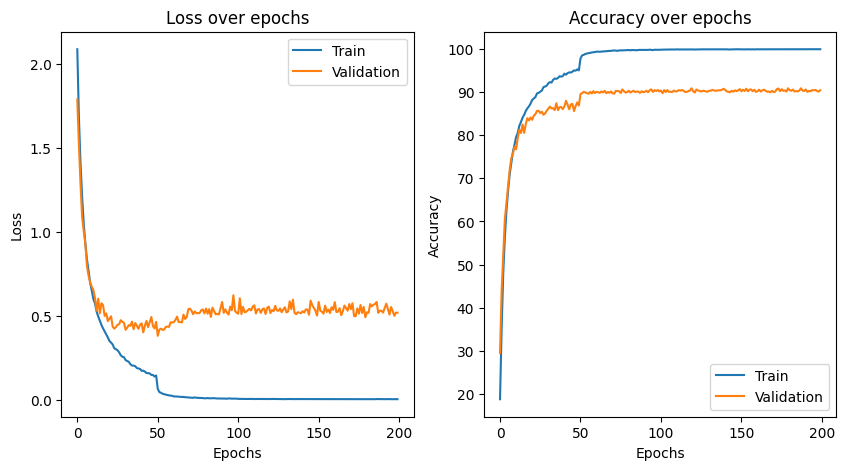

In [21]:
# Plotting
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train')
plt.plot(val_accuracies, label='Validation')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# CSI - train 

In [11]:
# Instantiate and load the model
model = VGG()  
model.load_state_dict(torch.load('best_model_weights.pth'))
model.to('cuda:1' if torch.cuda.is_available() else 'cpu')
model.eval()

# Prepare storage for outputs and labels
features_per_layer = [[] for _ in range(len(model.features))]
labels_list = []

# Function to attach hooks
def get_layer_outputs(layer_idx):
    def hook(module, input, output):
        features_per_layer[layer_idx].append(output.detach())
    return hook

# Attach hooks to each layer
for idx, layer in enumerate(model.features):
    layer.register_forward_hook(get_layer_outputs(idx))
    
# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(train_loader_SI):
        if torch.cuda.is_available():
            inputs = inputs.to('cuda:1')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets)

        # Release GPU memory
        del inputs
        torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for idx, layer_features in enumerate(features_per_layer):
    layer_features = torch.cat([f.view(f.size(0), -1) for f in layer_features])
    features_per_layer[idx] = layer_features

labels = torch.cat(labels_list)       

csi_layer_train = []

# Iterate through each layer's features in the dictionary
for features in features_per_layer:
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_train.append(csi) 

100%|██████████| 40/40 [00:00<00:00, 50.49it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2634.06it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3100.00it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3222.26it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3281.07it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2872.16it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2885.33it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3366.22it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3163.92it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3186.35it/s]

Data has been normalized



Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2889.30it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3080.27it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3104.59it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2820.65it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3419.27it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3084.05it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3155.98it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2887.31it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3241.35it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3054.10it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3354.55it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3163.13it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3220.61it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3319.15it/s]

Data has been normalized



Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3084.80it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2940.62it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3213.21it/s]

Data has been normalized



Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3109.96it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3186.35it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3115.35it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3229.70it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3029.11it/s]


In [12]:
print(len(csi_layer_train))
print(csi_layer_train)

31
[0.3773999810218811, 0.3773999810218811, 0.4553999900817871, 0.4553999900817871, 0.4633999764919281, 0.5349999666213989, 0.5349999666213989, 0.645799994468689, 0.645799994468689, 0.6255999803543091, 0.6739999651908875, 0.6739999651908875, 0.7333999872207642, 0.7333999872207642, 0.8405999541282654, 0.8405999541282654, 0.8357999920845032, 0.8804000020027161, 0.8804000020027161, 0.9279999732971191, 0.9279999732971191, 0.9541999697685242, 0.9541999697685242, 0.9615999460220337, 0.9829999804496765, 0.9829999804496765, 0.9847999811172485, 0.9847999811172485, 0.9839999675750732, 0.9839999675750732, 0.9845999479293823]


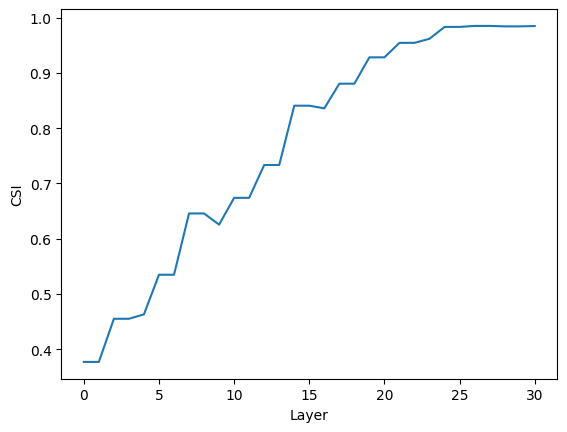

In [13]:
# plot csi vs layer for Train
plt.plot(csi_layer_train)
plt.xlabel('Layer')
plt.ylabel('CSI')
plt.show()

# CSI - Test

In [8]:
# Instantiate and load the model
model = VGG()  
model.load_state_dict(torch.load('best_model_weights.pth'))
model.to('cuda:1' if torch.cuda.is_available() else 'cpu')
model.eval()

# Prepare storage for outputs and labels
features_per_layer = [[] for _ in range(len(model.features))]
labels_list = []

# Function to attach hooks
def get_layer_outputs(layer_idx):
    def hook(module, input, output):
        features_per_layer[layer_idx].append(output.detach())
    return hook

# Attach hooks to each layer
for idx, layer in enumerate(model.features):
    layer.register_forward_hook(get_layer_outputs(idx))
    
    
# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(test_loader_SI):
        if torch.cuda.is_available():
            inputs = inputs.to('cuda:1')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets)

        # Release GPU memory
        del inputs
        torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for idx, layer_features in enumerate(features_per_layer):
    layer_features = torch.cat([f.view(f.size(0), -1) for f in layer_features])
    features_per_layer[idx] = layer_features

labels = torch.cat(labels_list)    
    

csi_layer_test = []

# Iterate through each layer's features in the dictionary
for features in features_per_layer:
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_test.append(csi) 

100%|██████████| 8/8 [00:00<00:00,  8.98it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 121.35it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 1985.00it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 1441.84it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 1474.27it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 1577.40it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 1375.18it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 1749.81it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 1569.72it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 1610.72it/s]

Data has been normalized



Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 1574.44it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 1633.93it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 1607.01it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 1569.14it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 1641.61it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 1812.58it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 1621.30it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 1479.47it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 1459.90it/s]

Data has been normalized



Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 1759.36it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 1639.04it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 1735.33it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 1708.47it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 1707.08it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 1458.89it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 1702.23it/s]

Data has been normalized



Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 1611.33it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 1565.04it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 1635.21it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 1612.57it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 1654.56it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 1650.00it/s]


In [9]:
print(len(csi_layer_test))
print(csi_layer_test)

31
[0.5110000371932983, 0.5110000371932983, 0.6470000147819519, 0.6470000147819519, 0.6260000467300415, 0.6960000395774841, 0.6960000395774841, 0.800000011920929, 0.800000011920929, 0.7410000562667847, 0.784000039100647, 0.784000039100647, 0.8060000538825989, 0.8060000538825989, 0.8890000581741333, 0.8890000581741333, 0.8470000624656677, 0.8610000610351562, 0.8610000610351562, 0.878000020980835, 0.878000020980835, 0.8840000629425049, 0.8840000629425049, 0.8840000629425049, 0.9010000228881836, 0.9010000228881836, 0.9050000309944153, 0.9050000309944153, 0.9020000696182251, 0.9020000696182251, 0.9040000438690186]


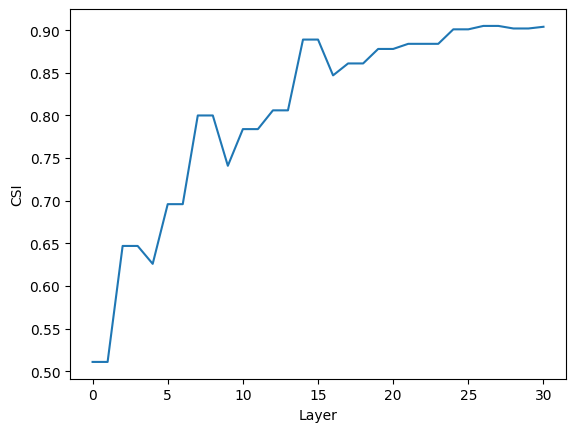

In [10]:
# plot csi vs layer for Train
plt.plot(csi_layer_test)
plt.xlabel('Layer')
plt.ylabel('CSI')
plt.show()

# train-test CSI

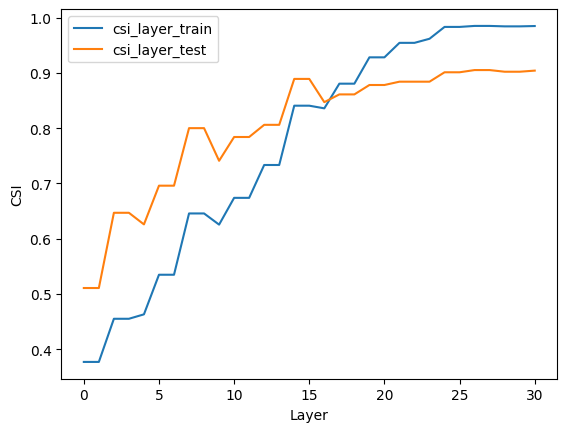

In [16]:
# plot csi vs layer for Train
plt.plot(csi_layer_train, label='csi_layer_train')
plt.plot(csi_layer_test, label='csi_layer_test')
plt.xlabel('Layer')
plt.legend()
plt.ylabel('CSI')
plt.show()

# Freeze- (train only FC)

In [4]:
# Instantiate the VGG model
vgg16 = VGG()

# Move the model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

# Load pre-trained weights (assuming you have a pre-trained model file)
pretrained_weights_path = "best_model_weights.pth"
state_dict = torch.load(pretrained_weights_path)

# Remove the classifier weights from the loaded state_dict
state_dict = {k: v for k, v in state_dict.items() if 'classifier' not in k}

# Load the modified state_dict into the model
vgg16.load_state_dict(state_dict, strict=False)

# Freeze layers before the classifier
for param in vgg16.features.parameters():
    param.requires_grad = False


## Train

In [25]:
# Define the loss function, optimizer, and learning rate scheduler with reduced learning rate
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = StepLR(optimizer, step_size=50, gamma=0.1)

In [26]:
import torch
from tqdm import tqdm

num_epochs = 200
best_val_accuracy = 0.0
patience = 20
early_stop_counter = 0
best_val_loss = float('inf')  # Initialize with a large value

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in tqdm(range(num_epochs)):
    vgg16.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
        optimizer.zero_grad()

        outputs = vgg16(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = 100 * correct_train / total_train
    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {running_loss / len(train_loader):.4f}, Train Acc: {train_accuracy:.2f}%')

    # Validation
    vgg16.eval()
    correct_val = 0
    total_val = 0
    val_loss = 0.0

    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
            outputs = vgg16(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_accuracy = 100 * correct_val / total_val
    print(f'Epoch {epoch + 1}/{num_epochs}, Val Loss: {val_loss / len(val_loader):.4f}, Val Acc: {val_accuracy:.2f}%')

    # Append values for plotting
    train_losses.append(running_loss / len(train_loader))
    val_losses.append(val_loss / len(val_loader))
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    # Save the model with the best validation accuracy
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(vgg16.state_dict(), 'only_fc_weights.pth')
        early_stop_counter = 0  # Reset the counter when there's an improvement
    else:
        early_stop_counter += 1  # Increment the counter if there's no improvement

    # Print early stopping information
    print(f'Epoch {epoch + 1}/{num_epochs}, Early Stop Counter: {early_stop_counter}/{patience}')

    # Check for early stopping
    if early_stop_counter >= patience:
        print(f'Early stopping after {epoch + 1} epochs without improvement in validation accuracy.')
        break  # Exit the training loop

    # Adjust learning rate
    scheduler.step()


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1/200, Train Loss: 0.1797, Train Acc: 98.05%
Epoch 1/200, Val Loss: 0.4449, Val Acc: 90.20%


  0%|          | 1/200 [00:09<32:52,  9.91s/it]

Epoch 1/200, Early Stop Counter: 0/20
Epoch 2/200, Train Loss: 0.0075, Train Acc: 99.87%
Epoch 2/200, Val Loss: 0.4748, Val Acc: 90.28%


  1%|          | 2/200 [00:20<34:05, 10.33s/it]

Epoch 2/200, Early Stop Counter: 0/20
Epoch 3/200, Train Loss: 0.0056, Train Acc: 99.91%
Epoch 3/200, Val Loss: 0.4997, Val Acc: 90.36%


  2%|▏         | 3/200 [00:31<34:47, 10.59s/it]

Epoch 3/200, Early Stop Counter: 0/20
Epoch 4/200, Train Loss: 0.0057, Train Acc: 99.88%
Epoch 4/200, Val Loss: 0.5007, Val Acc: 90.52%


  2%|▏         | 4/200 [00:42<35:41, 10.92s/it]

Epoch 4/200, Early Stop Counter: 0/20
Epoch 5/200, Train Loss: 0.0047, Train Acc: 99.91%


  2%|▎         | 5/200 [00:51<33:04, 10.18s/it]

Epoch 5/200, Val Loss: 0.5606, Val Acc: 90.40%
Epoch 5/200, Early Stop Counter: 1/20
Epoch 6/200, Train Loss: 0.0053, Train Acc: 99.89%


  3%|▎         | 6/200 [01:00<31:11,  9.65s/it]

Epoch 6/200, Val Loss: 0.5365, Val Acc: 90.32%
Epoch 6/200, Early Stop Counter: 2/20
Epoch 7/200, Train Loss: 0.0047, Train Acc: 99.88%


  4%|▎         | 7/200 [01:09<30:15,  9.41s/it]

Epoch 7/200, Val Loss: 0.5396, Val Acc: 90.30%
Epoch 7/200, Early Stop Counter: 3/20
Epoch 8/200, Train Loss: 0.0044, Train Acc: 99.90%


  4%|▍         | 8/200 [01:17<29:18,  9.16s/it]

Epoch 8/200, Val Loss: 0.5428, Val Acc: 90.34%
Epoch 8/200, Early Stop Counter: 4/20
Epoch 9/200, Train Loss: 0.0043, Train Acc: 99.90%


  4%|▍         | 9/200 [01:26<28:16,  8.88s/it]

Epoch 9/200, Val Loss: 0.5273, Val Acc: 90.30%
Epoch 9/200, Early Stop Counter: 5/20
Epoch 10/200, Train Loss: 0.0048, Train Acc: 99.89%


  5%|▌         | 10/200 [01:34<27:27,  8.67s/it]

Epoch 10/200, Val Loss: 0.5809, Val Acc: 90.10%
Epoch 10/200, Early Stop Counter: 6/20
Epoch 11/200, Train Loss: 0.0045, Train Acc: 99.89%


  6%|▌         | 11/200 [01:42<26:53,  8.53s/it]

Epoch 11/200, Val Loss: 0.5569, Val Acc: 90.48%
Epoch 11/200, Early Stop Counter: 7/20
Epoch 12/200, Train Loss: 0.0046, Train Acc: 99.89%


  6%|▌         | 12/200 [01:50<26:25,  8.43s/it]

Epoch 12/200, Val Loss: 0.5489, Val Acc: 90.50%
Epoch 12/200, Early Stop Counter: 8/20
Epoch 13/200, Train Loss: 0.0044, Train Acc: 99.88%


  6%|▋         | 13/200 [01:58<25:52,  8.30s/it]

Epoch 13/200, Val Loss: 0.5629, Val Acc: 90.12%
Epoch 13/200, Early Stop Counter: 9/20
Epoch 14/200, Train Loss: 0.0049, Train Acc: 99.86%


  7%|▋         | 14/200 [02:06<25:31,  8.23s/it]

Epoch 14/200, Val Loss: 0.5351, Val Acc: 90.12%
Epoch 14/200, Early Stop Counter: 10/20
Epoch 15/200, Train Loss: 0.0047, Train Acc: 99.86%


  8%|▊         | 15/200 [02:14<24:58,  8.10s/it]

Epoch 15/200, Val Loss: 0.5596, Val Acc: 90.28%
Epoch 15/200, Early Stop Counter: 11/20
Epoch 16/200, Train Loss: 0.0049, Train Acc: 99.86%


  8%|▊         | 16/200 [02:22<24:45,  8.07s/it]

Epoch 16/200, Val Loss: 0.5553, Val Acc: 90.18%
Epoch 16/200, Early Stop Counter: 12/20
Epoch 17/200, Train Loss: 0.0048, Train Acc: 99.88%


  8%|▊         | 17/200 [02:30<24:34,  8.06s/it]

Epoch 17/200, Val Loss: 0.5300, Val Acc: 90.50%
Epoch 17/200, Early Stop Counter: 13/20
Epoch 18/200, Train Loss: 0.0044, Train Acc: 99.89%


  9%|▉         | 18/200 [02:38<24:39,  8.13s/it]

Epoch 18/200, Val Loss: 0.5237, Val Acc: 90.28%
Epoch 18/200, Early Stop Counter: 14/20
Epoch 19/200, Train Loss: 0.0049, Train Acc: 99.87%


 10%|▉         | 19/200 [02:47<24:31,  8.13s/it]

Epoch 19/200, Val Loss: 0.5780, Val Acc: 90.14%
Epoch 19/200, Early Stop Counter: 15/20
Epoch 20/200, Train Loss: 0.0050, Train Acc: 99.87%
Epoch 20/200, Val Loss: 0.5292, Val Acc: 90.54%


 10%|█         | 20/200 [02:58<26:56,  8.98s/it]

Epoch 20/200, Early Stop Counter: 0/20
Epoch 21/200, Train Loss: 0.0043, Train Acc: 99.88%


 10%|█         | 21/200 [03:06<25:52,  8.67s/it]

Epoch 21/200, Val Loss: 0.5510, Val Acc: 90.18%
Epoch 21/200, Early Stop Counter: 1/20
Epoch 22/200, Train Loss: 0.0042, Train Acc: 99.88%
Epoch 22/200, Val Loss: 0.5319, Val Acc: 90.62%


 11%|█         | 22/200 [03:16<27:14,  9.18s/it]

Epoch 22/200, Early Stop Counter: 0/20
Epoch 23/200, Train Loss: 0.0048, Train Acc: 99.88%


 12%|█▏        | 23/200 [03:25<26:43,  9.06s/it]

Epoch 23/200, Val Loss: 0.5380, Val Acc: 89.94%
Epoch 23/200, Early Stop Counter: 1/20
Epoch 24/200, Train Loss: 0.0042, Train Acc: 99.90%


 12%|█▏        | 24/200 [03:33<26:03,  8.88s/it]

Epoch 24/200, Val Loss: 0.5534, Val Acc: 90.28%
Epoch 24/200, Early Stop Counter: 2/20
Epoch 25/200, Train Loss: 0.0043, Train Acc: 99.89%


 12%|█▎        | 25/200 [03:41<25:20,  8.69s/it]

Epoch 25/200, Val Loss: 0.5082, Val Acc: 90.56%
Epoch 25/200, Early Stop Counter: 3/20
Epoch 26/200, Train Loss: 0.0046, Train Acc: 99.88%


 13%|█▎        | 26/200 [03:50<24:54,  8.59s/it]

Epoch 26/200, Val Loss: 0.5251, Val Acc: 90.60%
Epoch 26/200, Early Stop Counter: 4/20
Epoch 27/200, Train Loss: 0.0040, Train Acc: 99.92%


 14%|█▎        | 27/200 [03:58<24:52,  8.63s/it]

Epoch 27/200, Val Loss: 0.5304, Val Acc: 90.36%
Epoch 27/200, Early Stop Counter: 5/20
Epoch 28/200, Train Loss: 0.0043, Train Acc: 99.90%


 14%|█▍        | 28/200 [04:07<24:20,  8.49s/it]

Epoch 28/200, Val Loss: 0.5398, Val Acc: 90.42%
Epoch 28/200, Early Stop Counter: 6/20
Epoch 29/200, Train Loss: 0.0038, Train Acc: 99.93%


 14%|█▍        | 29/200 [04:15<23:48,  8.36s/it]

Epoch 29/200, Val Loss: 0.5595, Val Acc: 90.50%
Epoch 29/200, Early Stop Counter: 7/20
Epoch 30/200, Train Loss: 0.0042, Train Acc: 99.90%
Epoch 30/200, Val Loss: 0.5224, Val Acc: 90.64%


 15%|█▌        | 30/200 [04:25<25:44,  9.09s/it]

Epoch 30/200, Early Stop Counter: 0/20
Epoch 31/200, Train Loss: 0.0043, Train Acc: 99.90%


 16%|█▌        | 31/200 [04:34<24:59,  8.87s/it]

Epoch 31/200, Val Loss: 0.5534, Val Acc: 90.52%
Epoch 31/200, Early Stop Counter: 1/20
Epoch 32/200, Train Loss: 0.0044, Train Acc: 99.88%


 16%|█▌        | 32/200 [04:42<24:21,  8.70s/it]

Epoch 32/200, Val Loss: 0.5114, Val Acc: 90.32%
Epoch 32/200, Early Stop Counter: 2/20
Epoch 33/200, Train Loss: 0.0041, Train Acc: 99.90%


 16%|█▋        | 33/200 [04:51<24:18,  8.73s/it]

Epoch 33/200, Val Loss: 0.5640, Val Acc: 90.18%
Epoch 33/200, Early Stop Counter: 3/20
Epoch 34/200, Train Loss: 0.0048, Train Acc: 99.87%


 17%|█▋        | 34/200 [04:59<23:58,  8.66s/it]

Epoch 34/200, Val Loss: 0.5290, Val Acc: 90.38%
Epoch 34/200, Early Stop Counter: 4/20
Epoch 35/200, Train Loss: 0.0047, Train Acc: 99.88%


 18%|█▊        | 35/200 [05:08<23:41,  8.61s/it]

Epoch 35/200, Val Loss: 0.5273, Val Acc: 90.50%
Epoch 35/200, Early Stop Counter: 5/20
Epoch 36/200, Train Loss: 0.0047, Train Acc: 99.87%


 18%|█▊        | 36/200 [05:16<23:30,  8.60s/it]

Epoch 36/200, Val Loss: 0.5218, Val Acc: 90.18%
Epoch 36/200, Early Stop Counter: 6/20
Epoch 37/200, Train Loss: 0.0036, Train Acc: 99.93%


 18%|█▊        | 37/200 [05:25<23:25,  8.62s/it]

Epoch 37/200, Val Loss: 0.5711, Val Acc: 89.86%
Epoch 37/200, Early Stop Counter: 7/20
Epoch 38/200, Train Loss: 0.0041, Train Acc: 99.91%


 19%|█▉        | 38/200 [05:34<23:17,  8.62s/it]

Epoch 38/200, Val Loss: 0.5504, Val Acc: 90.26%
Epoch 38/200, Early Stop Counter: 8/20
Epoch 39/200, Train Loss: 0.0044, Train Acc: 99.90%


 20%|█▉        | 39/200 [05:43<23:19,  8.69s/it]

Epoch 39/200, Val Loss: 0.5422, Val Acc: 90.48%
Epoch 39/200, Early Stop Counter: 9/20
Epoch 40/200, Train Loss: 0.0040, Train Acc: 99.91%


 20%|██        | 40/200 [05:51<22:40,  8.50s/it]

Epoch 40/200, Val Loss: 0.5387, Val Acc: 89.94%
Epoch 40/200, Early Stop Counter: 10/20
Epoch 41/200, Train Loss: 0.0042, Train Acc: 99.91%


 20%|██        | 41/200 [05:59<22:23,  8.45s/it]

Epoch 41/200, Val Loss: 0.5411, Val Acc: 90.24%
Epoch 41/200, Early Stop Counter: 11/20
Epoch 42/200, Train Loss: 0.0041, Train Acc: 99.91%


 21%|██        | 42/200 [06:07<21:50,  8.29s/it]

Epoch 42/200, Val Loss: 0.5509, Val Acc: 90.54%
Epoch 42/200, Early Stop Counter: 12/20
Epoch 43/200, Train Loss: 0.0045, Train Acc: 99.90%


 22%|██▏       | 43/200 [06:14<21:04,  8.06s/it]

Epoch 43/200, Val Loss: 0.5278, Val Acc: 90.24%
Epoch 43/200, Early Stop Counter: 13/20
Epoch 44/200, Train Loss: 0.0041, Train Acc: 99.91%


 22%|██▏       | 44/200 [06:23<20:59,  8.07s/it]

Epoch 44/200, Val Loss: 0.5461, Val Acc: 90.20%
Epoch 44/200, Early Stop Counter: 14/20
Epoch 45/200, Train Loss: 0.0042, Train Acc: 99.90%


 22%|██▎       | 45/200 [06:31<20:58,  8.12s/it]

Epoch 45/200, Val Loss: 0.5475, Val Acc: 90.14%
Epoch 45/200, Early Stop Counter: 15/20
Epoch 46/200, Train Loss: 0.0042, Train Acc: 99.89%


 23%|██▎       | 46/200 [06:39<20:54,  8.14s/it]

Epoch 46/200, Val Loss: 0.5489, Val Acc: 90.32%
Epoch 46/200, Early Stop Counter: 16/20
Epoch 47/200, Train Loss: 0.0041, Train Acc: 99.90%


 24%|██▎       | 47/200 [06:47<20:51,  8.18s/it]

Epoch 47/200, Val Loss: 0.5453, Val Acc: 89.70%
Epoch 47/200, Early Stop Counter: 17/20
Epoch 48/200, Train Loss: 0.0039, Train Acc: 99.91%


 24%|██▍       | 48/200 [06:56<20:47,  8.21s/it]

Epoch 48/200, Val Loss: 0.5368, Val Acc: 90.02%
Epoch 48/200, Early Stop Counter: 18/20
Epoch 49/200, Train Loss: 0.0042, Train Acc: 99.90%


 24%|██▍       | 49/200 [07:04<20:37,  8.19s/it]

Epoch 49/200, Val Loss: 0.5395, Val Acc: 90.04%
Epoch 49/200, Early Stop Counter: 19/20
Epoch 50/200, Train Loss: 0.0038, Train Acc: 99.91%


 24%|██▍       | 49/200 [07:12<22:12,  8.83s/it]

Epoch 50/200, Val Loss: 0.6191, Val Acc: 90.20%
Epoch 50/200, Early Stop Counter: 20/20
Early stopping after 50 epochs without improvement in validation accuracy.


## Results

In [27]:
# Testing loop
vgg16.eval()
correct_test = 0
total_test = 0

with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
        outputs = vgg16(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

test_accuracy = 100 * correct_test / total_test
print(f'Test Accuracy: {test_accuracy:.2f}%')

Test Accuracy: 90.56%


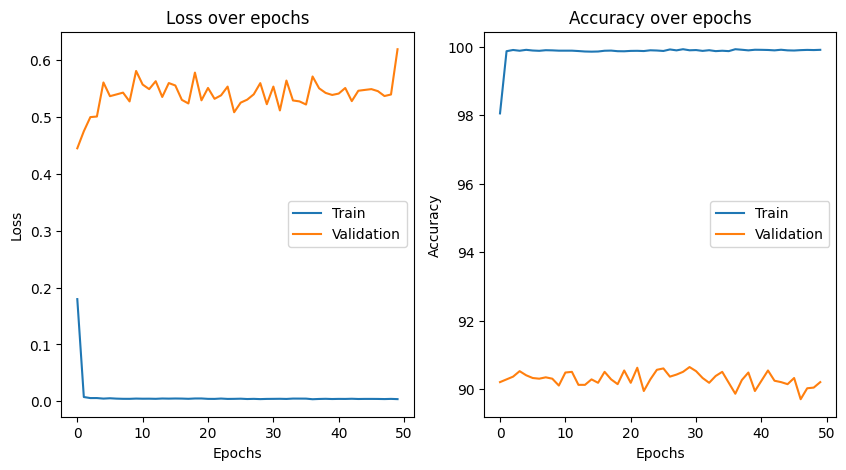

In [28]:
# Plotting
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train')
plt.plot(val_accuracies, label='Validation')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# CSI - train 

In [13]:
# Instantiate and load the model
model = VGG()  
model.load_state_dict(torch.load('only_fc_weights.pth'))
model.to('cuda:1' if torch.cuda.is_available() else 'cpu')
model.eval()

# Prepare storage for outputs and labels
features_per_layer = [[] for _ in range(len(model.features))]
labels_list = []

# Function to attach hooks
def get_layer_outputs(layer_idx):
    def hook(module, input, output):
        features_per_layer[layer_idx].append(output.detach())
    return hook

# Attach hooks to each layer
for idx, layer in enumerate(model.features):
    layer.register_forward_hook(get_layer_outputs(idx))
    
# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(train_loader_SI):
        if torch.cuda.is_available():
            inputs = inputs.to('cuda:1')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets)

        # Release GPU memory
        del inputs
        torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for idx, layer_features in enumerate(features_per_layer):
    layer_features = torch.cat([f.view(f.size(0), -1) for f in layer_features])
    features_per_layer[idx] = layer_features

labels = torch.cat(labels_list)       

csi_layer_train = []

# Iterate through each layer's features in the dictionary
for features in features_per_layer:
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_train.append(csi) 

100%|██████████| 40/40 [00:00<00:00, 55.44it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3237.18it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3247.20it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3182.32it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3141.02it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3025.47it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3199.32it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3025.47it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2969.77it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3093.14it/s]

Data has been normalized



Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2415.15it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3102.30it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3146.51it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3050.40it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2942.68it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3209.11it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3203.39it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3153.61it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2207.14it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2271.69it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2228.64it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2215.30it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2295.31it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2206.75it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3106.89it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3389.79it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2984.56it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3314.78it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3029.84it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3249.72it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2992.37it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3061.54it/s]


In [14]:
print(len(csi_layer_train))
print(csi_layer_train)

31
[0.3879999816417694, 0.3879999816417694, 0.4702000021934509, 0.4702000021934509, 0.48159998655319214, 0.555400013923645, 0.555400013923645, 0.6606000065803528, 0.6606000065803528, 0.6359999775886536, 0.6854000091552734, 0.6854000091552734, 0.7297999858856201, 0.7297999858856201, 0.8309999704360962, 0.8309999704360962, 0.8312000036239624, 0.8729999661445618, 0.8729999661445618, 0.9231999516487122, 0.9231999516487122, 0.9487999677658081, 0.9487999677658081, 0.9587999582290649, 0.9819999933242798, 0.9819999933242798, 0.9869999885559082, 0.9869999885559082, 0.9871999621391296, 0.9871999621391296, 0.9869999885559082]


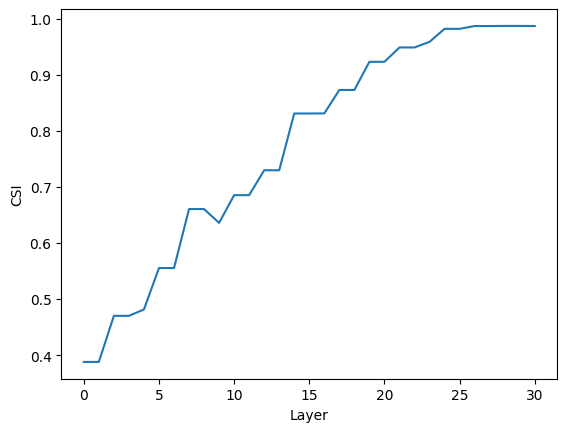

In [15]:
# plot csi vs layer for Train
plt.plot(csi_layer_train)
plt.xlabel('Layer')
plt.ylabel('CSI')
plt.show()

# CSI - test 

In [16]:
# Instantiate and load the model
model = VGG()  
model.load_state_dict(torch.load('only_fc_weights.pth'))
model.to('cuda:1' if torch.cuda.is_available() else 'cpu')
model.eval()

# Prepare storage for outputs and labels
features_per_layer = [[] for _ in range(len(model.features))]
labels_list = []

# Function to attach hooks
def get_layer_outputs(layer_idx):
    def hook(module, input, output):
        features_per_layer[layer_idx].append(output.detach())
    return hook

# Attach hooks to each layer
for idx, layer in enumerate(model.features):
    layer.register_forward_hook(get_layer_outputs(idx))
    
    
# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(test_loader_SI):
        if torch.cuda.is_available():
            inputs = inputs.to('cuda:1')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets)

        # Release GPU memory
        del inputs
        torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for idx, layer_features in enumerate(features_per_layer):
    layer_features = torch.cat([f.view(f.size(0), -1) for f in layer_features])
    features_per_layer[idx] = layer_features

labels = torch.cat(labels_list)    
    

csi_layer_test = []

# Iterate through each layer's features in the dictionary
for features in features_per_layer:
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_test.append(csi) 

100%|██████████| 8/8 [00:00<00:00, 15.94it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 1617.55it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 1592.37it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 1682.43it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 1594.79it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 1672.37it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 1720.39it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 1189.20it/s]

Data has been normalized



Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 1585.75it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 1525.76it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 925.08it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 1582.16it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 1610.10it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 1559.22it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 1563.87it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 1632.02it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 1546.00it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 1673.04it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 1084.36it/s]

Data has been normalized



Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 1043.88it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 1051.99it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 936.65it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 1104.05it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 1059.70it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 1416.52it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 1621.30it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 1585.15it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 1654.56it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 1754.20it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 1705.69it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 2274.57it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 2257.43it/s]


In [17]:
print(len(csi_layer_test))
print(csi_layer_test)

31
[0.492000013589859, 0.492000013589859, 0.625, 0.625, 0.6110000014305115, 0.6770000457763672, 0.6770000457763672, 0.7910000085830688, 0.7910000085830688, 0.7470000386238098, 0.7800000309944153, 0.7800000309944153, 0.7980000376701355, 0.7980000376701355, 0.8750000596046448, 0.8750000596046448, 0.8360000252723694, 0.8440000414848328, 0.8440000414848328, 0.8650000691413879, 0.8650000691413879, 0.8730000257492065, 0.8730000257492065, 0.8770000338554382, 0.89000004529953, 0.89000004529953, 0.8960000276565552, 0.8960000276565552, 0.89000004529953, 0.89000004529953, 0.8970000147819519]


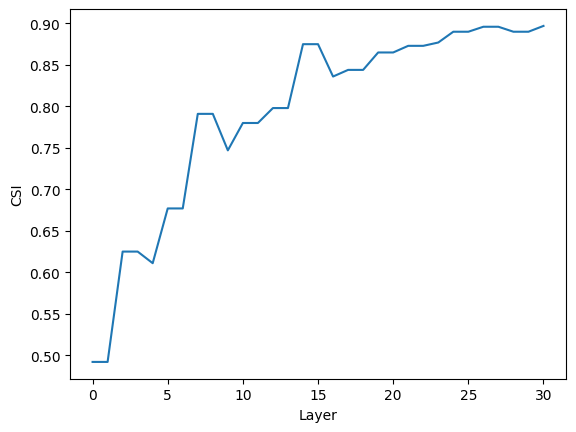

In [18]:
# plot csi vs layer for Train
plt.plot(csi_layer_test)
plt.xlabel('Layer')
plt.ylabel('CSI')
plt.show()

# train- test CSI freeze

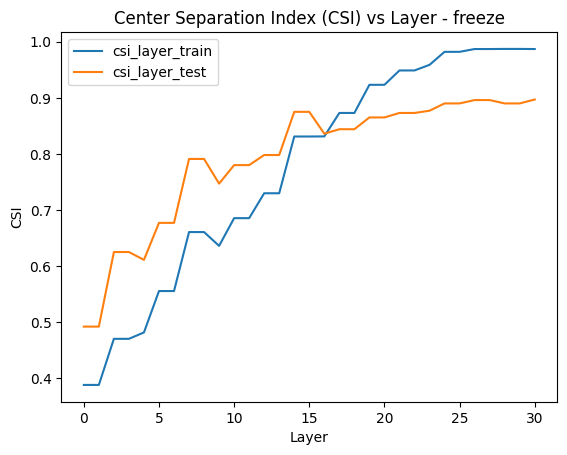

In [19]:
# plot csi vs layer for Train
plt.plot(csi_layer_train, label='csi_layer_train')
plt.plot(csi_layer_test, label='csi_layer_test')
plt.xlabel('Layer')
plt.legend()
plt.title('Center Separation Index (CSI) vs Layer - freeze')
plt.ylabel('CSI')
plt.show()